<a href="https://colab.research.google.com/github/BigOyayubi/PyTorchTutorial/blob/master/PyTorch1_1_GettingStarted_03_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://torch.classcat.com/2019/06/23/pytorch-1-1-getting-started-neural-networks/

PyTorch1.1 > チュートリアル > ニューラルネットワークの動作確認メモです。

以下CNNを実装します。MNIST向けでチュートリアルとは少し異なります。

![代替テキスト](http://torch.classcat.com/wp-content/uploads/2018/12/pytorch10-gstarted-nn_mnist.png)

ざっくりとした実装の流れは

*   nn.Moduleを継承してニューラルネットワークモデル定義
*   データセット準備
*   学習
*   テスト

です。

In [3]:
#ネットワーク定義

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
 
    # __init__でモデルのパラメータ未定な層のサイズを決める
    def __init__(self):
        super(Net, self).__init__()
        #C1 グレイスケール画像1チャンネル入力、出力6チャンネル、カーネルサイズ5x5なフィルタ
        # MNIST画像サイズ28x28 -> 26x26になる
        self.conv1 = nn.Conv2d(1, 6, 3)
        #S2 画像サイズを半分に 26x26 -> 13x13
        #チュートリアルでは単純に画像サイズ半分にするため、pool2は定義しない
        self.pool2 = nn.MaxPool2d(2)
        #C3 6チャンネル入力、出力16チャンネル、カーネルサイズ3x3なフィルタ
        # 画像サイズ13x13 -> 11x11になる
        self.conv3 = nn.Conv2d(6, 16, 3)
        #S4 画像サイズを半分に 11x11 -> 5x5になる
        self.pool4 = nn.MaxPool2d(2)
        #C5 結合層 入力16チャンネルx画像サイズ5x5、出力120チャンネル
        # an affine operation: y = Wx + b
        self.fc5 = nn.Linear(16 * 5 * 5, 120)  # 6*6 from image dimension
        #F6 結合層 入力120チャンネル、出力84チャンネル
        self.fc6 = nn.Linear(120, 84)
        #output 入力84、出力10
        self.out = nn.Linear(84, 10)
 
    # forwardでデータ順伝搬を式指定して具体化
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.out(x)
        return x
 
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
 
 
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc5): Linear(in_features=400, out_features=120, bias=True)
  (fc6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
#モデルの学習可能なパラメータを確認する
params = list(net.parameters())
print(len(params))
print(params[0].size()) #conv1

10
torch.Size([6, 1, 3, 3])


In [5]:
#ダミー値を流し込んで動作確認
dummy_in = torch.randn(1, 1, 28, 28)
dummy_out = net(dummy_in)
#0〜9の合致具合が返る
print(dummy_out.size())
print(dummy_out)

torch.Size([1, 10])
tensor([[ 0.0608,  0.0211,  0.1057,  0.0031, -0.0777,  0.1090, -0.0243,  0.0919,
          0.0042,  0.1462]], grad_fn=<AddmmBackward>)


In [0]:
#学習用データを取得
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

#画像正規化
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5,))])

# データセットをダウンロード
# 学習用
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

#検証用
test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)


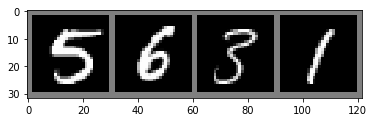

5 6 3 1


In [21]:
#取得したデータを表示して中身確認
import matplotlib.pyplot as plt
import numpy as np
 
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
data = dataiter.next()
images, labels = data
imshow(torchvision.utils.make_grid(images))
print(' '.join('%s' % labels[i].item() for i in range(4)))

In [41]:
#損失関数を使って計算結果が正解からどれだけ離れているか推定します
use_mseloss = True
if use_mseloss:
  # 平均二乗誤差
  # 出力が0〜9の確率列なので、比較する正解はone-hot表現にしないといけない
  criterion = nn.MSELoss()
else:
  #交差エントロピー
  # 出力0〜9の確率列で、マッチ度合いが高い列があれば正解に近い＝損失が小さい
  criterion = nn.CrossEntropyLoss()

#ダミー入力で損失関数まで計算してみる
dummy_out = net(dummy_in)
#ダミー正解
if use_mseloss:
  #one-hot
  dummy_labels = torch.randn(10).view(1,-1) #正規分布平均0,分散1でランダム10要素
else:
  #1入力なので対になるダミー正解数字
  dummy_labels = torch.LongTensor(1).random_(0, 10)
print(dummy_labels)

dummy_loss = criterion(dummy_out, dummy_labels)
print(dummy_loss)

#loss.backward() を呼び出す時、グラフ全体は損失に関して微分され、requires_grad=True を持つグラフの総ての Tensor は勾配が累積されたそれらの .grad Tensor を持ちます。
print(dummy_loss.grad_fn)
print(dummy_loss.grad_fn.next_functions[0][0])
print(dummy_loss.grad_fn.next_functions[0][0].next_functions[0][0])

#誤差逆伝播はloss.backword()で行います。実施前に累積な既存勾配はクリアすることに注意
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
dummy_loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

#パラメータの更新はtorch.optimから任意のものを選ぶ
#今回はSGD
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer.zero_grad()
dummy_out = net(dummy_in)
loss = criterion(dummy_out, dummy_labels)
loss.backward()
optimizer.step()


tensor([[ 0.1474,  1.7920,  0.0824,  0.8670, -1.6170, -2.0604,  1.0318,  0.8185,
         -1.2666,  0.9650]])
tensor(1.4895, grad_fn=<MseLossBackward>)
conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0017, -0.0056,  0.0144, -0.0175,  0.0086, -0.0069])


In [46]:
#実際に学習、テストしてみる。重いのでGPUで
#GPUで計算する場合、modelとtensorをto(device)で変換する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

#モデル
net = Net().to(device)
#損失関数
use_mseloss = True
if use_mseloss:
  criterion = nn.MSELoss()
else:
  criterion = nn.CrossEntropyLoss()
#最適化関数
optimizer = optim.SGD(net.parameters(), lr=0.01)

def to_one_hot(labels):
  return torch.eye(10)[labels]

#学習
for epoch in range(3):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    #勾配をクリア
    optimizer.zero_grad()

    #forward
    outputs = net(inputs)

    #損失関数計算
    if use_mseloss:
      #one-hotにする
      labels = to_one_hot(labels).to(device)
    loss = criterion(outputs, labels)

    #逆伝搬
    loss.backward()

    #パラメータ更新
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')


cuda:0
[1,  2000] loss: 0.088
[1,  4000] loss: 0.074
[1,  6000] loss: 0.055
[1,  8000] loss: 0.044
[1, 10000] loss: 0.037
[1, 12000] loss: 0.031
[1, 14000] loss: 0.027
[2,  2000] loss: 0.022
[2,  4000] loss: 0.020
[2,  6000] loss: 0.019
[2,  8000] loss: 0.018
[2, 10000] loss: 0.017
[2, 12000] loss: 0.016
[2, 14000] loss: 0.015
[3,  2000] loss: 0.014
[3,  4000] loss: 0.013
[3,  6000] loss: 0.013
[3,  8000] loss: 0.012
[3, 10000] loss: 0.012
[3, 12000] loss: 0.012
[3, 14000] loss: 0.011
Finished Training


label 8 pred 3


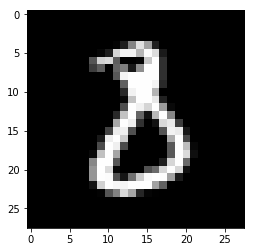

label 2 pred 3


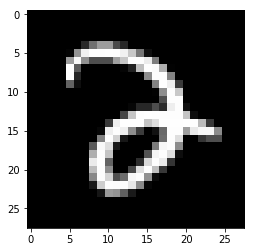

label 7 pred 2


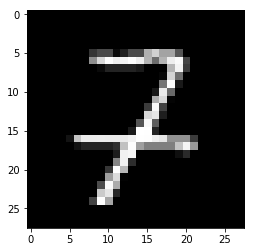

label 3 pred 7


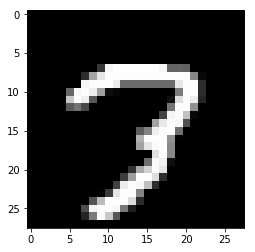

label 6 pred 0


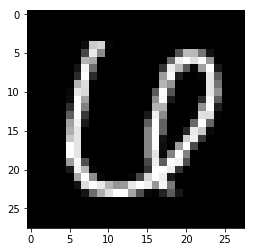

label 2 pred 8


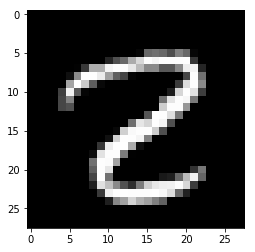

label 5 pred 9


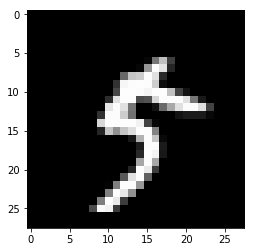

label 9 pred 3


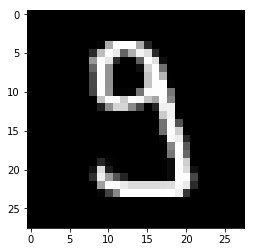

label 8 pred 9


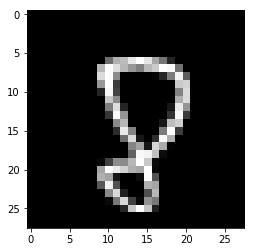

label 7 pred 2


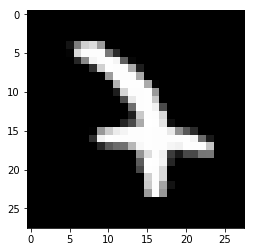

label 9 pred 4


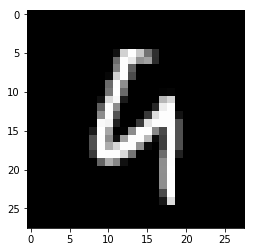

label 7 pred 0


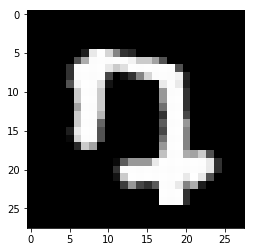

label 9 pred 7


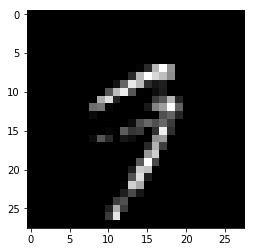

label 4 pred 6


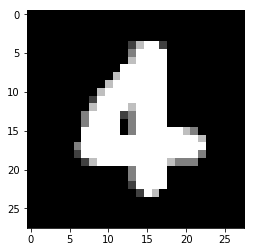

label 9 pred 7


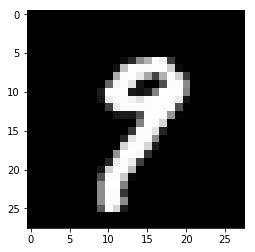

label 8 pred 5


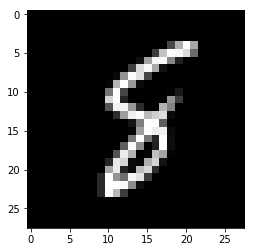

Accuracy of the network on the 10000 test images: 96 %


In [56]:
#学習結果を確認する
correct = 0
total = 0
wrong = 0
with torch.no_grad(): #勾配追跡不要設定
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) #値列->値な最大なインデックス列にして返す
    total += labels.size(0) #評価総数
    check = predicted == labels #インデックス列と正解列の比較結果(True or False)列
    correct += check.sum().item() #正解総数

    #誤判定した画像出してみる
    for i in range(labels.size(0)):
      if not check[i]:
        wrong += 1
        if wrong % 20 == 0:
          print('label %d pred %d' % (labels[i].item(), predicted[i]))
          imshow(torchvision.utils.make_grid(images[i].cpu()))

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))